# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

A subdirectory or file data already exists.


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

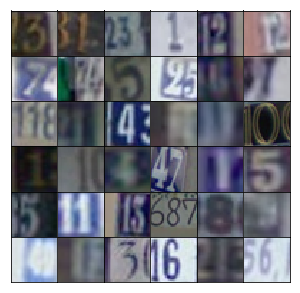

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [18]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

print_every=50
show_every=1000

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 0.1499... Generator Loss: 2.9810
Epoch 1/25... Discriminator Loss: 0.5442... Generator Loss: 1.8975
Epoch 1/25... Discriminator Loss: 0.5797... Generator Loss: 1.4403
Epoch 1/25... Discriminator Loss: 0.9201... Generator Loss: 0.9762
Epoch 1/25... Discriminator Loss: 1.0693... Generator Loss: 1.8335
Epoch 1/25... Discriminator Loss: 0.9241... Generator Loss: 1.4584
Epoch 1/25... Discriminator Loss: 0.5251... Generator Loss: 1.4390
Epoch 1/25... Discriminator Loss: 1.4257... Generator Loss: 0.4608
Epoch 1/25... Discriminator Loss: 0.3974... Generator Loss: 2.4253
Epoch 1/25... Discriminator Loss: 1.5696... Generator Loss: 0.3839
Epoch 1/25... Discriminator Loss: 0.7856... Generator Loss: 1.2604
Epoch 2/25... Discriminator Loss: 1.3538... Generator Loss: 0.4780
Epoch 2/25... Discriminator Loss: 0.8232... Generator Loss: 1.1855
Epoch 2/25... Discriminator Loss: 0.8759... Generator Loss: 1.2940
Epoch 2/25... Discriminator Loss: 0.6102... Generator Loss: 1.

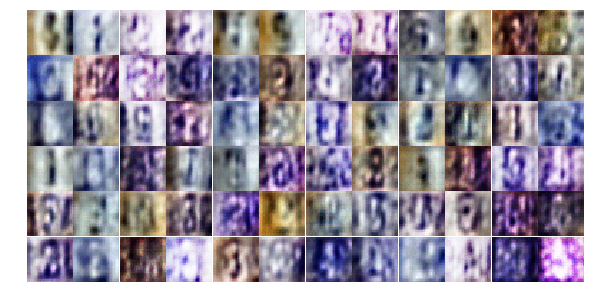

Epoch 2/25... Discriminator Loss: 1.0844... Generator Loss: 0.7726
Epoch 2/25... Discriminator Loss: 0.9974... Generator Loss: 0.9892
Epoch 3/25... Discriminator Loss: 0.8937... Generator Loss: 1.5573
Epoch 3/25... Discriminator Loss: 0.7834... Generator Loss: 1.2742
Epoch 3/25... Discriminator Loss: 0.9451... Generator Loss: 0.7639
Epoch 3/25... Discriminator Loss: 0.8278... Generator Loss: 0.9697
Epoch 3/25... Discriminator Loss: 0.8475... Generator Loss: 0.9397
Epoch 3/25... Discriminator Loss: 0.7264... Generator Loss: 1.0056
Epoch 3/25... Discriminator Loss: 0.7941... Generator Loss: 2.3522
Epoch 3/25... Discriminator Loss: 0.6766... Generator Loss: 1.3091
Epoch 3/25... Discriminator Loss: 0.3685... Generator Loss: 1.8930
Epoch 3/25... Discriminator Loss: 0.7265... Generator Loss: 1.5856
Epoch 3/25... Discriminator Loss: 0.3989... Generator Loss: 1.9869
Epoch 3/25... Discriminator Loss: 0.4798... Generator Loss: 1.4896
Epoch 4/25... Discriminator Loss: 0.6894... Generator Loss: 1.

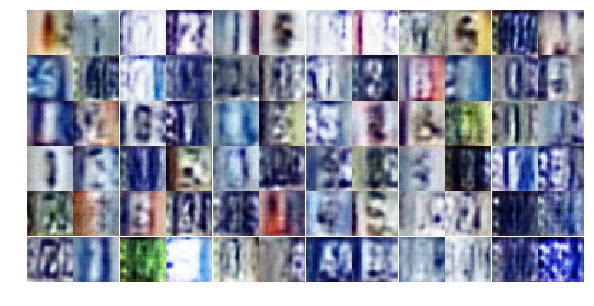

Epoch 4/25... Discriminator Loss: 0.4102... Generator Loss: 1.8137
Epoch 4/25... Discriminator Loss: 0.7330... Generator Loss: 1.8500
Epoch 4/25... Discriminator Loss: 0.5390... Generator Loss: 2.4393
Epoch 4/25... Discriminator Loss: 0.4905... Generator Loss: 1.7233
Epoch 4/25... Discriminator Loss: 0.6113... Generator Loss: 1.1283
Epoch 5/25... Discriminator Loss: 0.5765... Generator Loss: 1.2262
Epoch 5/25... Discriminator Loss: 0.5267... Generator Loss: 2.9949
Epoch 5/25... Discriminator Loss: 0.5480... Generator Loss: 1.3390
Epoch 5/25... Discriminator Loss: 0.7551... Generator Loss: 1.0356
Epoch 5/25... Discriminator Loss: 0.4499... Generator Loss: 1.7080
Epoch 5/25... Discriminator Loss: 0.7314... Generator Loss: 0.9161
Epoch 5/25... Discriminator Loss: 0.8139... Generator Loss: 2.4871
Epoch 5/25... Discriminator Loss: 0.8461... Generator Loss: 1.7841
Epoch 5/25... Discriminator Loss: 0.7826... Generator Loss: 0.9007
Epoch 5/25... Discriminator Loss: 0.7681... Generator Loss: 1.

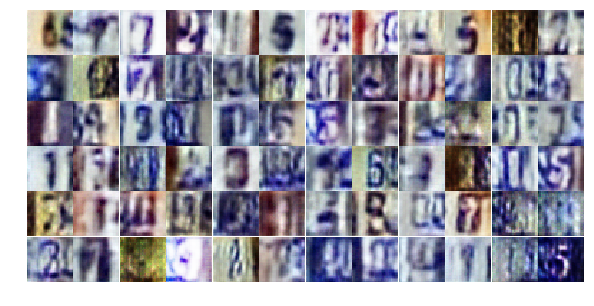

Epoch 6/25... Discriminator Loss: 0.5876... Generator Loss: 1.6164
Epoch 6/25... Discriminator Loss: 1.0655... Generator Loss: 0.5660
Epoch 6/25... Discriminator Loss: 0.7251... Generator Loss: 3.4916
Epoch 6/25... Discriminator Loss: 0.4973... Generator Loss: 1.4438
Epoch 6/25... Discriminator Loss: 0.5229... Generator Loss: 1.5550
Epoch 6/25... Discriminator Loss: 0.5481... Generator Loss: 1.7555
Epoch 6/25... Discriminator Loss: 0.5041... Generator Loss: 1.5713
Epoch 6/25... Discriminator Loss: 1.8582... Generator Loss: 0.2550
Epoch 7/25... Discriminator Loss: 0.7358... Generator Loss: 1.2224
Epoch 7/25... Discriminator Loss: 1.8309... Generator Loss: 0.2345
Epoch 7/25... Discriminator Loss: 0.5044... Generator Loss: 1.4186
Epoch 7/25... Discriminator Loss: 0.8891... Generator Loss: 0.7292
Epoch 7/25... Discriminator Loss: 0.3195... Generator Loss: 1.9668
Epoch 7/25... Discriminator Loss: 0.8636... Generator Loss: 2.9794
Epoch 7/25... Discriminator Loss: 0.7396... Generator Loss: 0.

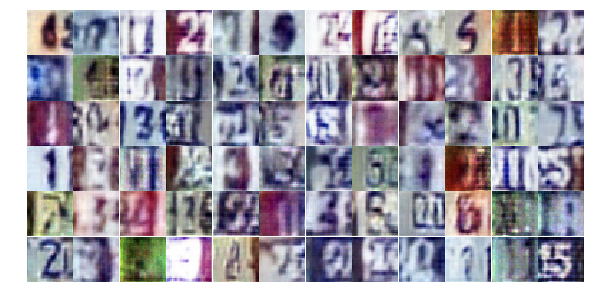

Epoch 8/25... Discriminator Loss: 0.6750... Generator Loss: 1.0966
Epoch 8/25... Discriminator Loss: 0.5600... Generator Loss: 1.5518
Epoch 8/25... Discriminator Loss: 1.3160... Generator Loss: 0.4031
Epoch 8/25... Discriminator Loss: 1.3590... Generator Loss: 1.5037
Epoch 8/25... Discriminator Loss: 0.3362... Generator Loss: 2.4989
Epoch 8/25... Discriminator Loss: 0.8710... Generator Loss: 0.7314
Epoch 8/25... Discriminator Loss: 1.2228... Generator Loss: 0.4670
Epoch 8/25... Discriminator Loss: 0.7444... Generator Loss: 0.9196
Epoch 8/25... Discriminator Loss: 1.6492... Generator Loss: 3.8017
Epoch 8/25... Discriminator Loss: 0.6510... Generator Loss: 1.1714
Epoch 8/25... Discriminator Loss: 0.6441... Generator Loss: 1.4188
Epoch 9/25... Discriminator Loss: 0.6643... Generator Loss: 2.1094
Epoch 9/25... Discriminator Loss: 0.8891... Generator Loss: 0.7317
Epoch 9/25... Discriminator Loss: 0.8681... Generator Loss: 0.7313
Epoch 9/25... Discriminator Loss: 0.5396... Generator Loss: 1.

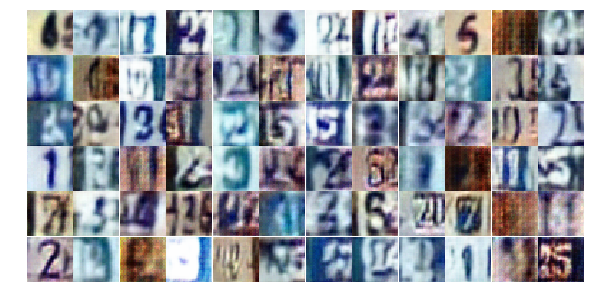

Epoch 9/25... Discriminator Loss: 0.6902... Generator Loss: 2.4543
Epoch 9/25... Discriminator Loss: 0.6010... Generator Loss: 1.7488
Epoch 9/25... Discriminator Loss: 0.9600... Generator Loss: 0.7223
Epoch 10/25... Discriminator Loss: 1.1472... Generator Loss: 0.5134
Epoch 10/25... Discriminator Loss: 0.5075... Generator Loss: 1.5610
Epoch 10/25... Discriminator Loss: 0.6004... Generator Loss: 1.6398
Epoch 10/25... Discriminator Loss: 0.5856... Generator Loss: 1.3677
Epoch 10/25... Discriminator Loss: 0.3589... Generator Loss: 2.4446
Epoch 10/25... Discriminator Loss: 0.7585... Generator Loss: 1.2768
Epoch 10/25... Discriminator Loss: 4.3742... Generator Loss: 6.5736
Epoch 10/25... Discriminator Loss: 0.7099... Generator Loss: 1.0193
Epoch 10/25... Discriminator Loss: 0.6150... Generator Loss: 2.1001
Epoch 10/25... Discriminator Loss: 0.5207... Generator Loss: 1.5103
Epoch 10/25... Discriminator Loss: 0.6095... Generator Loss: 1.2031
Epoch 11/25... Discriminator Loss: 0.6321... Genera

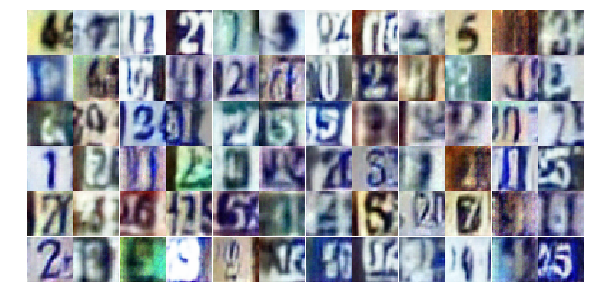

Epoch 11/25... Discriminator Loss: 0.8291... Generator Loss: 0.7946
Epoch 11/25... Discriminator Loss: 1.4340... Generator Loss: 0.3656
Epoch 11/25... Discriminator Loss: 0.8763... Generator Loss: 0.7192
Epoch 11/25... Discriminator Loss: 0.5101... Generator Loss: 1.6076
Epoch 11/25... Discriminator Loss: 1.3263... Generator Loss: 0.3995
Epoch 11/25... Discriminator Loss: 0.9242... Generator Loss: 0.7780
Epoch 12/25... Discriminator Loss: 0.4952... Generator Loss: 1.3632
Epoch 12/25... Discriminator Loss: 1.0240... Generator Loss: 0.6518
Epoch 12/25... Discriminator Loss: 0.5707... Generator Loss: 1.5673
Epoch 12/25... Discriminator Loss: 0.8345... Generator Loss: 0.8090
Epoch 12/25... Discriminator Loss: 0.4735... Generator Loss: 1.5999
Epoch 12/25... Discriminator Loss: 0.5173... Generator Loss: 1.5476
Epoch 12/25... Discriminator Loss: 0.7183... Generator Loss: 1.0659
Epoch 12/25... Discriminator Loss: 0.3907... Generator Loss: 1.7370
Epoch 12/25... Discriminator Loss: 0.8248... Gen

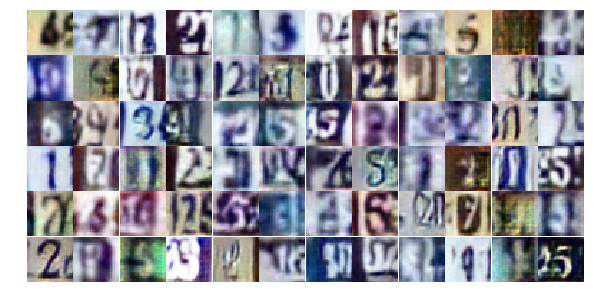

Epoch 13/25... Discriminator Loss: 1.2053... Generator Loss: 2.6162
Epoch 13/25... Discriminator Loss: 0.9952... Generator Loss: 0.6272
Epoch 13/25... Discriminator Loss: 0.9226... Generator Loss: 0.6887
Epoch 13/25... Discriminator Loss: 0.6440... Generator Loss: 1.2591
Epoch 13/25... Discriminator Loss: 0.7644... Generator Loss: 0.9993
Epoch 13/25... Discriminator Loss: 0.7618... Generator Loss: 0.8171
Epoch 13/25... Discriminator Loss: 0.9464... Generator Loss: 0.6664
Epoch 13/25... Discriminator Loss: 0.8375... Generator Loss: 0.7910
Epoch 14/25... Discriminator Loss: 0.9759... Generator Loss: 0.6443
Epoch 14/25... Discriminator Loss: 0.9099... Generator Loss: 0.7228
Epoch 14/25... Discriminator Loss: 1.2134... Generator Loss: 0.5382
Epoch 14/25... Discriminator Loss: 1.3554... Generator Loss: 0.4228
Epoch 14/25... Discriminator Loss: 0.8809... Generator Loss: 0.7686
Epoch 14/25... Discriminator Loss: 0.5135... Generator Loss: 1.3691
Epoch 14/25... Discriminator Loss: 0.5135... Gen

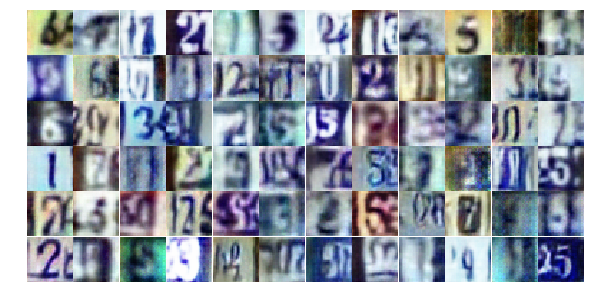

Epoch 15/25... Discriminator Loss: 0.6441... Generator Loss: 1.3149
Epoch 15/25... Discriminator Loss: 1.2193... Generator Loss: 1.6703
Epoch 15/25... Discriminator Loss: 0.8526... Generator Loss: 0.9600
Epoch 15/25... Discriminator Loss: 0.8972... Generator Loss: 0.8038
Epoch 15/25... Discriminator Loss: 1.1226... Generator Loss: 0.5781
Epoch 15/25... Discriminator Loss: 1.1842... Generator Loss: 0.5489
Epoch 15/25... Discriminator Loss: 0.5678... Generator Loss: 1.2299
Epoch 15/25... Discriminator Loss: 0.6797... Generator Loss: 1.1161
Epoch 15/25... Discriminator Loss: 0.6642... Generator Loss: 1.0115
Epoch 15/25... Discriminator Loss: 0.9267... Generator Loss: 0.8459
Epoch 15/25... Discriminator Loss: 0.6928... Generator Loss: 0.9779
Epoch 16/25... Discriminator Loss: 1.2884... Generator Loss: 0.4497
Epoch 16/25... Discriminator Loss: 0.6007... Generator Loss: 1.6791
Epoch 16/25... Discriminator Loss: 0.6468... Generator Loss: 1.3136
Epoch 16/25... Discriminator Loss: 0.4113... Gen

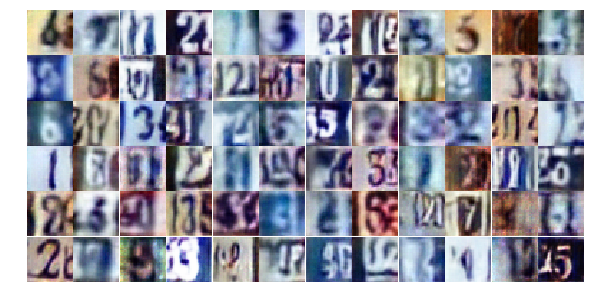

Epoch 16/25... Discriminator Loss: 0.8344... Generator Loss: 0.8363
Epoch 16/25... Discriminator Loss: 1.0325... Generator Loss: 0.6031
Epoch 16/25... Discriminator Loss: 0.7764... Generator Loss: 0.8529
Epoch 17/25... Discriminator Loss: 0.8406... Generator Loss: 0.7958
Epoch 17/25... Discriminator Loss: 1.2001... Generator Loss: 0.5374
Epoch 17/25... Discriminator Loss: 0.6751... Generator Loss: 1.3619
Epoch 17/25... Discriminator Loss: 0.7510... Generator Loss: 1.0336
Epoch 17/25... Discriminator Loss: 0.6695... Generator Loss: 1.0430
Epoch 17/25... Discriminator Loss: 1.6233... Generator Loss: 0.3307
Epoch 17/25... Discriminator Loss: 0.4571... Generator Loss: 1.5832
Epoch 17/25... Discriminator Loss: 0.7727... Generator Loss: 0.9708
Epoch 17/25... Discriminator Loss: 0.6606... Generator Loss: 1.0264
Epoch 17/25... Discriminator Loss: 0.9842... Generator Loss: 0.6759
Epoch 17/25... Discriminator Loss: 1.6337... Generator Loss: 0.3095
Epoch 18/25... Discriminator Loss: 1.0639... Gen

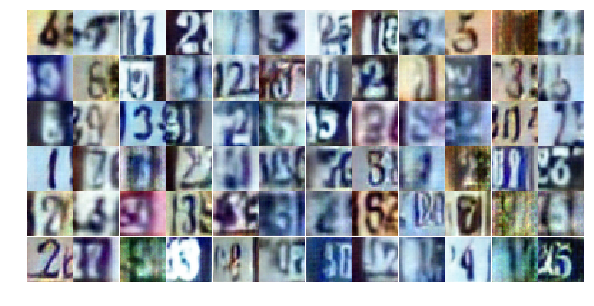

Epoch 18/25... Discriminator Loss: 0.7781... Generator Loss: 0.8251
Epoch 18/25... Discriminator Loss: 0.8270... Generator Loss: 0.9655
Epoch 18/25... Discriminator Loss: 0.6213... Generator Loss: 1.1280
Epoch 18/25... Discriminator Loss: 1.1524... Generator Loss: 1.3097
Epoch 18/25... Discriminator Loss: 0.7353... Generator Loss: 0.9894
Epoch 18/25... Discriminator Loss: 0.8411... Generator Loss: 0.8042
Epoch 19/25... Discriminator Loss: 0.6915... Generator Loss: 1.0125
Epoch 19/25... Discriminator Loss: 1.2813... Generator Loss: 0.4893
Epoch 19/25... Discriminator Loss: 0.8443... Generator Loss: 0.7742
Epoch 19/25... Discriminator Loss: 1.1700... Generator Loss: 0.5545
Epoch 19/25... Discriminator Loss: 1.0500... Generator Loss: 0.6147
Epoch 19/25... Discriminator Loss: 1.7549... Generator Loss: 0.2900
Epoch 19/25... Discriminator Loss: 1.1429... Generator Loss: 0.5435
Epoch 19/25... Discriminator Loss: 0.8813... Generator Loss: 0.7447
Epoch 19/25... Discriminator Loss: 0.7308... Gen

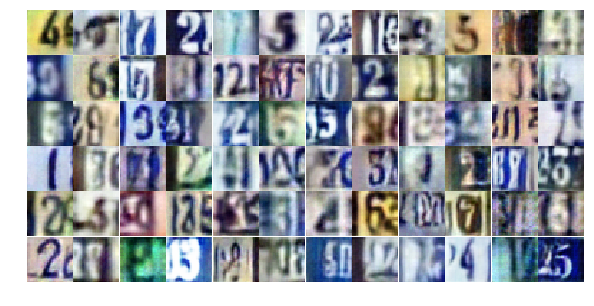

Epoch 20/25... Discriminator Loss: 1.0087... Generator Loss: 0.6690
Epoch 20/25... Discriminator Loss: 1.3889... Generator Loss: 0.4198
Epoch 20/25... Discriminator Loss: 1.2791... Generator Loss: 0.4619
Epoch 20/25... Discriminator Loss: 0.6082... Generator Loss: 1.1382
Epoch 20/25... Discriminator Loss: 0.6531... Generator Loss: 1.1550
Epoch 20/25... Discriminator Loss: 0.9409... Generator Loss: 0.6569
Epoch 20/25... Discriminator Loss: 0.7044... Generator Loss: 1.1425
Epoch 20/25... Discriminator Loss: 0.6950... Generator Loss: 1.0557
Epoch 20/25... Discriminator Loss: 0.5734... Generator Loss: 1.2065
Epoch 21/25... Discriminator Loss: 1.2422... Generator Loss: 0.4843
Epoch 21/25... Discriminator Loss: 0.8144... Generator Loss: 0.8882
Epoch 21/25... Discriminator Loss: 1.1261... Generator Loss: 0.5793
Epoch 21/25... Discriminator Loss: 0.7122... Generator Loss: 1.4155
Epoch 21/25... Discriminator Loss: 0.8268... Generator Loss: 0.8718
Epoch 21/25... Discriminator Loss: 0.8523... Gen

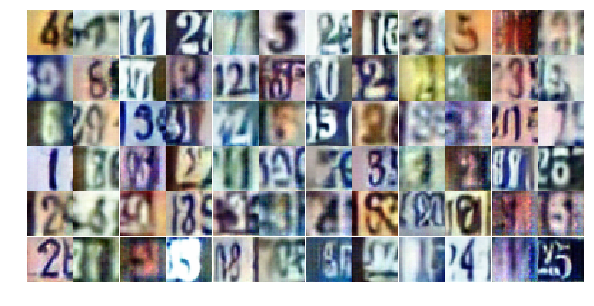

Epoch 22/25... Discriminator Loss: 0.9639... Generator Loss: 0.7464
Epoch 22/25... Discriminator Loss: 0.8048... Generator Loss: 0.8194
Epoch 22/25... Discriminator Loss: 0.9988... Generator Loss: 0.7014
Epoch 22/25... Discriminator Loss: 1.8104... Generator Loss: 0.2910
Epoch 22/25... Discriminator Loss: 0.5058... Generator Loss: 1.6395
Epoch 22/25... Discriminator Loss: 1.3105... Generator Loss: 0.5004
Epoch 22/25... Discriminator Loss: 0.7504... Generator Loss: 1.0876
Epoch 22/25... Discriminator Loss: 1.0421... Generator Loss: 0.6609
Epoch 22/25... Discriminator Loss: 0.5513... Generator Loss: 1.1932
Epoch 22/25... Discriminator Loss: 0.8547... Generator Loss: 0.7705
Epoch 22/25... Discriminator Loss: 0.5422... Generator Loss: 1.3678
Epoch 22/25... Discriminator Loss: 0.8530... Generator Loss: 0.8178
Epoch 23/25... Discriminator Loss: 0.6311... Generator Loss: 1.2718
Epoch 23/25... Discriminator Loss: 0.3878... Generator Loss: 1.6361
Epoch 23/25... Discriminator Loss: 0.5364... Gen

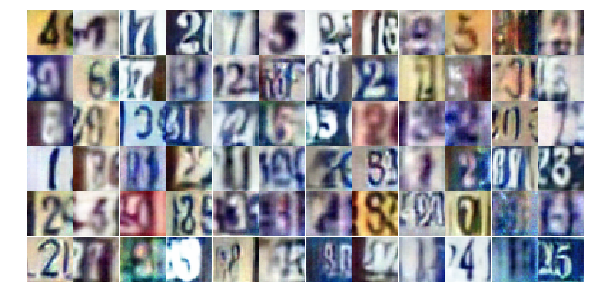

Epoch 23/25... Discriminator Loss: 0.8059... Generator Loss: 2.5923
Epoch 23/25... Discriminator Loss: 0.9201... Generator Loss: 0.8810
Epoch 23/25... Discriminator Loss: 1.4130... Generator Loss: 0.4140
Epoch 24/25... Discriminator Loss: 0.8239... Generator Loss: 1.6779
Epoch 24/25... Discriminator Loss: 0.7173... Generator Loss: 0.9194
Epoch 24/25... Discriminator Loss: 0.4830... Generator Loss: 1.7182
Epoch 24/25... Discriminator Loss: 1.7554... Generator Loss: 2.8626
Epoch 24/25... Discriminator Loss: 1.4230... Generator Loss: 0.6637
Epoch 24/25... Discriminator Loss: 1.3594... Generator Loss: 0.8117
Epoch 24/25... Discriminator Loss: 0.9904... Generator Loss: 0.8122
Epoch 24/25... Discriminator Loss: 1.0707... Generator Loss: 0.6886
Epoch 24/25... Discriminator Loss: 0.7171... Generator Loss: 1.0575
Epoch 24/25... Discriminator Loss: 1.2611... Generator Loss: 0.4943
Epoch 24/25... Discriminator Loss: 1.0915... Generator Loss: 0.6329
Epoch 24/25... Discriminator Loss: 0.9792... Gen

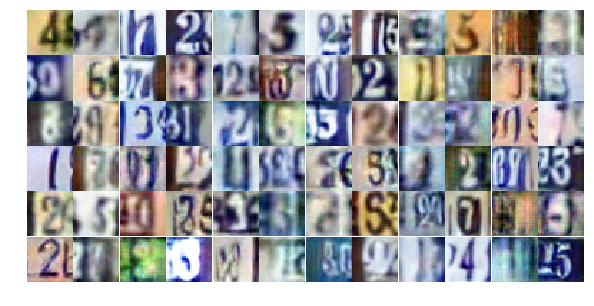

Epoch 25/25... Discriminator Loss: 0.9643... Generator Loss: 0.6905
Epoch 25/25... Discriminator Loss: 0.5889... Generator Loss: 1.3940
Epoch 25/25... Discriminator Loss: 1.0841... Generator Loss: 0.5589
Epoch 25/25... Discriminator Loss: 0.6497... Generator Loss: 1.0582
Epoch 25/25... Discriminator Loss: 1.0100... Generator Loss: 0.6528
Epoch 25/25... Discriminator Loss: 1.9140... Generator Loss: 0.2730


In [19]:
dataset = Dataset(trainset, testset)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5), print_every=print_every, show_every=show_every)

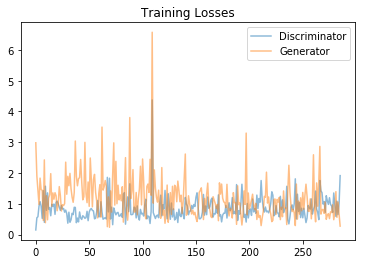

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

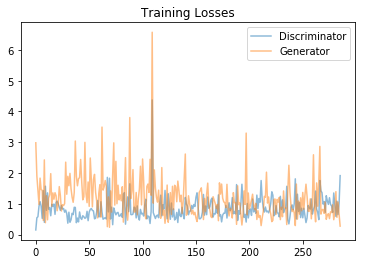

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

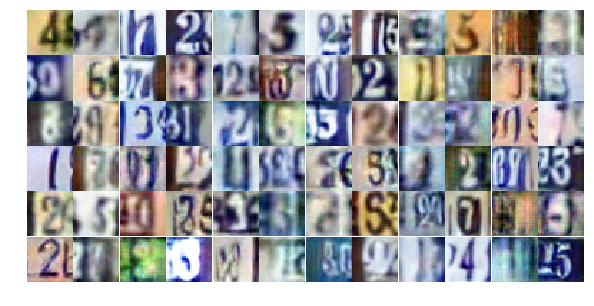

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))